This is the workflow for getting a new earthquake catalog. We have totally 5 steps:
1. Download `.mseed` seismic data
2. Data preprocessing
3. Phase picking using [PhaseNet-TF](https://github.com/ziyixi/PhaseNet-TF)
4. Earthquake association using [GaMMA](https://github.com/AI4EPS/GaMMA)
5. Earthquake relocation using tomodd (optional)

## Data downloading
The input are .mseed waveforms from [IRIS](https://www.iris.edu/hq/), which is a seismic data center. I used [massdownloader](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html) function of [Obspy](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html) to download data. Since I have my own package, I created a example [script](./data/download.py) here. You may need to modify some parameters to meet your need. You can download data with any different lengths, we will index it anyway.

Before start I suggest to create a basic seismology environment first, with obspy and some different packages. This envrionment will be for casual use, you can install any related packages here, so that it will not affect the environments for future steps.

! Node that you need to download anaconda in case you don't have.

In [ ]:
# create a new anaconda environment called seis
! conda create -n seis python = 3.9
# active your seis environment
! conda activate seis
# download package
! conda install conda-forge::obspy

After downloading data, we can use [index](./data/index.py) to log them into a database for convinient accessing. Then you can access your data by running:

In [11]:
from obspy.clients.filesystem.tsindex import Client as sql_client
from obspy import UTCDateTime

starttime = UTCDateTime('1989-12-08T10:50:00') # modify parameters to fit your data
sq_client = sql_client("/mnt/scratch/jieyaqi/alaska/datalong.sqlite") # you can change to your own database
st = sq_client.get_waveforms_bulk(
            [("SH", "BAL", "*", "*", starttime - 60, starttime + 60)], None)

/mnt/home/jieyaqi/anaconda3/envs/pntf/lib/python3.9/site-packages/obspy/clients/filesystem/tsindex.py:1672: SAWarning: SELECT statement has a cartesian product between FROM element(s) "raw_request_cte" and FROM element "tsindex".  Apply join condition(s) between each element to resolve.
  for rt in result:


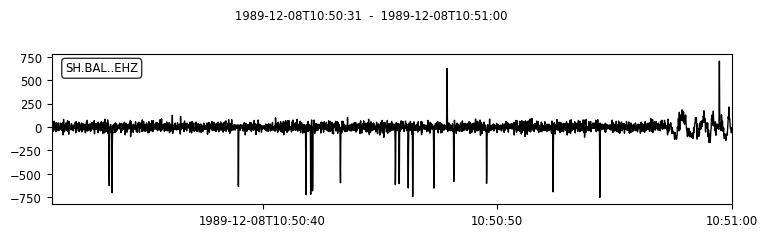

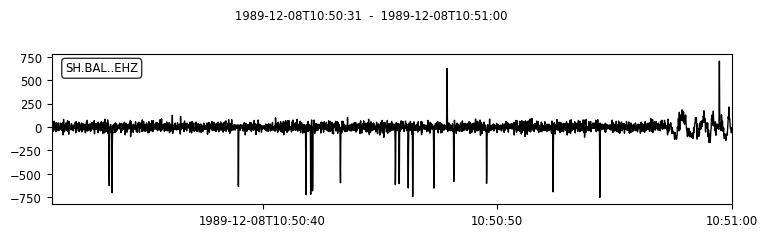

In [12]:
# Your data can be plotted like:
st.plot()

## Data preparation
All data need to be preprocessed for prediction, including:
- merge to remove duplications
- resample to 40
- fill the gaps with 0

This [script](./data/preprocessing.py) can use multiple CPUs to process your data, for example, I usually use 250 cores. If you process on your own laptop, it may take some time, but you can stop processing and resume anytime without duplication. 

Then [index](./data/index.py) the processed data again.

## Phase Picking
We use [PhaseNet-TF](https://github.com/ziyixi/PhaseNet-TF) to perform phase picking. I fixed a small bug that nan could be induced in the data [here](https://github.com/Aaaapril4/PhaseNet-TF), but PS predictiion is not mergerd yet, you can choose whichever version you want, the procedures are the same.

### Install the environment
To install:
1. clone the repo into the directory
2. install the [Poetry](https://python-poetry.org/docs/), which is a environment management tool like anaconda (you can follow the doc to install Poetry, but if you decide to install it on icer, I suggest to use conda to install Poetry)
3. create a python virtual environment
4. use poetry to install the environment

In [ ]:
# ! cd /path/to/code
# clone the repo in to the directory
! git clone git@github.com:Aaaapril4/PhaseNet-TF.git

In [ ]:
# load the python environment and create new virtual environment
# if you run on HPC
# ! module purge
# ! module load GCC/11.3.0
# ! module load Python/3.10.4-GCCcore-11.3.0

! python3 -m venv ~/phasenet-tf

In [ ]:
# now you can activate the environment and you should see a (phasenet-tf) at the first of the command if you are using terminal
! source ~/phasenet-tf/bin/activate

In [13]:
# check your python version first, you need to make your conda and the virtual environment have the same version of Python (we need 3.9 at least)
! python3 --version

Python 3.9.17


In [ ]:
# install poetry using conda
! conda create -n pntf python=3.10.4 # make sure the version is the same with yours
! conda activate pntf
! conda install conda-forge::poetry

In [ ]:
# you should see something like: Poetry (version 1.4.0) here if you install successfully
! poetry --version

In [ ]:
# before install the PhaseNet-TF, make sure the virtual environment and the conda environment are both activated, 
# and change to the phaseNet-TF directory
# you don't need to activate the conda environment in future use, unless you need to install it again
! cd PhaseNet-TF
! rm *lock
! poetry install --with train

Now the PhaseNet-TF is installed, here is the last step, you can use any code editor or even terminal, open `~/phasenet-tf/lib/python3.10/site-packages/obspy/clients/filesystem/tsindex.py` and increase the parallel number to 500
Then activate the environment again

### Phase precdiction
To start prediction, you need to prepare
- a .sqlite database
- a .csv file for all traces need to be processed
- create a new directory to save output
- create a yaml file under PhaseNet-TF/configs/experiment, you may need to change some parameters, for example:
    - modify configs/hydra if you run on hpcc
    - modify configs/paths if you need to train a new model
        - change the path to checkpoint in configs/train.yaml
        
If you need to process a large dataset on icer, I suggest to split the dataset into several small pieces (less than 4 hours per piece) to save the queue time. You can use [split_data.py](./prediction/split_data.py) and [merge_result.sh](./prediction/merge_result.sh) as reference. As a reference, I predict 150 - 200 10-day mseed files using 1 node (4 v100 GPU) for 2-3 hours.

In [ ]:
#To do the prediction:
! cd /code/to/phasenet-tf
# for hpcc
! python3 -m src.predict --multirun hydra/launcher=submitit_slurm experiment=alaska # use the name of your parameter.yaml file here
# for local
! python3 -m src.predict experiment=alaska # use the name of your parameter.yaml file here

After prediction, you will get one or more phase_arrival.csv files, and some .mseed files for probability output if you choose to save.

## Association
We will use [GaMMA](https://github.com/AI4EPS/GaMMA) to associate those predicted phases as earthquakes. To install, just clone the repo and install using setup.py

Then you can run the [association](./Association/assotiation.py)

In [ ]:
# create a new environment for GaMMA
! conda create -n gamma python=3.10
! conda activate gamma

In [ ]:
! pip install git+https://github.com/wayneweiqiang/GaMMA.git

# or

# clong the repo and install (I prefer this one though)
! git clone git@github.com:AI4EPS/GaMMA.git
! cd GaMMA
! python3 setup.py install